In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [15]:
words = open('./LLM/names.txt', 'r').read().splitlines()
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)

In [22]:
class Linear:
    def __init__(self,fan_in,fan_out,bias =True):
        self.weight = torch.randn((fan_in,fan_out), generator=g)/fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self,x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ( [] if self.bias is None else [self.bias])

In [67]:
class BatchNorm1d:

    def __init__(self,dim,eps=1e-5,momentum = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        # parameters trained with backprop
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        #buffers trained with a running 'momentum update'ArithmeticError
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)


    def __call__(self,x):

        #calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim = True) # batch mean
            xvar = x.var(0, keepdim = True) #batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean)/torch.sqrt(xvar+self.eps) #normalize to unit variance
        self.out = self.gamma*xhat + self.beta

        #update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum)* self.running_mean + self.momentum * xmean
                self.running_var = (1- self.momentum)*self.running_var + self.momentum*xvar

            return self.out
        
    def parameters(self):
        return [self.gamma, self.beta]









In [25]:
class Tanh:
    def __call__(self,x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return[]

In [50]:
n_embd = 10 # the dimensionality of the charcter embedding vectors
n_hidden = 100
g = torch.Generator().manual_seed(2147483647) 
C = torch.randn((vocab_size,n_embd), generator=g)
block_size = 3

In [51]:
layers = [
    Linear(n_embd*block_size,n_hidden),Tanh(),
    Linear(n_hidden,n_hidden),Tanh(),
    Linear(n_hidden,n_hidden),Tanh(),
    Linear(n_hidden,n_hidden),Tanh(),
    Linear(n_hidden,n_hidden),Tanh(),
    Linear(n_hidden,vocab_size),


]

with torch.no_grad():
    # last layer : make less confident
    layers[-1].weight *=0.1

    #all other layers : apply gain
    for layer in layers[:-1]:
        if isinstance(layer,Linear):
            layer.weight *=5/3


parameters = [C] + [p for layer in layers for p in layer.parameters()]

print( sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

46497


In [29]:
def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [52]:
max_steps  = 200000
batch_size = 32
lossi =[]
ud = []
for i in range(max_steps):

    #minibatch construct
    ix = torch.randint(0,Xtr.shape[0],(batch_size,),generator=g)
    Xb,Yb = Xtr[ix],Ytr[ix] # batch X, Y

    #forward pass
    emb = C[Xb] #embed the characters into vectors
    x =emb.view(emb.shape[0],-1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) #loss function

    #backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG :would take out retain_graph

    for p in parameters:
        p.grad = None
    loss.backward()

    # update

    lr = 0.1 if i < 100000 else 0.01

    for p in parameters:
        p.data  += -lr * p.grad


    #track stats
    
    if i % 10000 == 0: # print every once n a while

        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')

    lossi.append(loss.log10().item())

    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])
    
    if i >= 1000:
        break # AFTER_DEBUG: would take out obviously to run full optimization  





      0/ 200000: 3.2962


layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.62%
layer 5 (      Tanh): mean +0.00, std 0.64, saturated: 2.47%
layer 8 (      Tanh): mean -0.00, std 0.64, saturated: 2.16%
layer 11 (      Tanh): mean +0.00, std 0.65, saturated: 1.81%
layer 14 (      Tanh): mean -0.00, std 0.65, saturated: 1.78%


Text(0.5, 1.0, 'Activation Distribution')

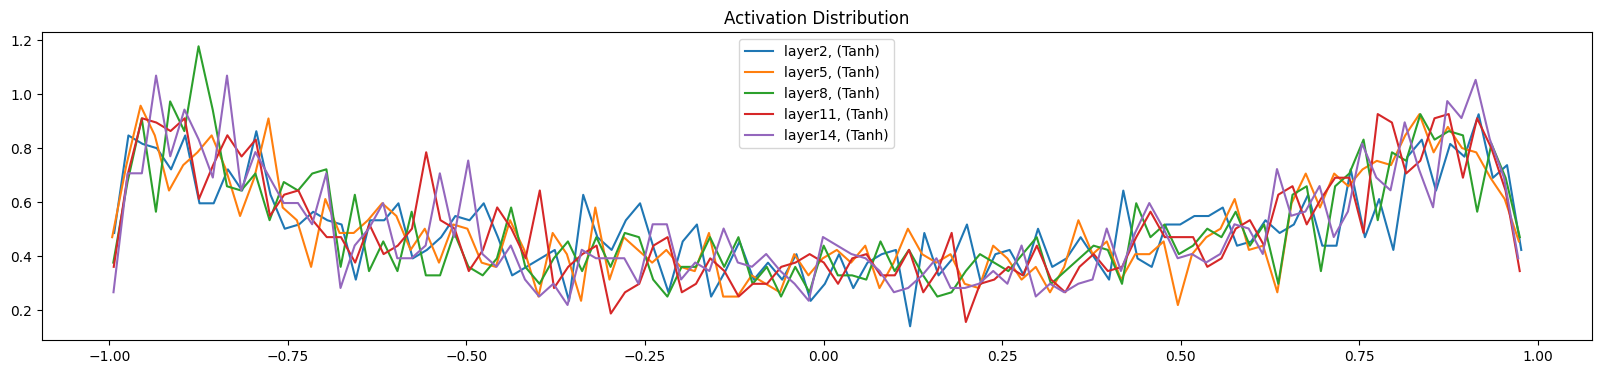

In [70]:
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy,hx = torch.histogram(t,density=True)
        plt.plot(hx[:-1].detach(),hy.detach())
        legends.append(f'layer{i}, ({layer.__class__.__name__})')
plt.legend(legends);
plt.title("Activation Distribution")

layer 2 (      Tanh): mean +0.000000, std 3.682957e-03
layer 5 (      Tanh): mean -0.000000, std 3.262611e-03
layer 8 (      Tanh): mean -0.000000, std 2.973732e-03
layer 11 (      Tanh): mean +0.000000, std 2.741112e-03
layer 14 (      Tanh): mean +0.000000, std 2.584294e-03


Text(0.5, 1.0, 'gradient distribution')

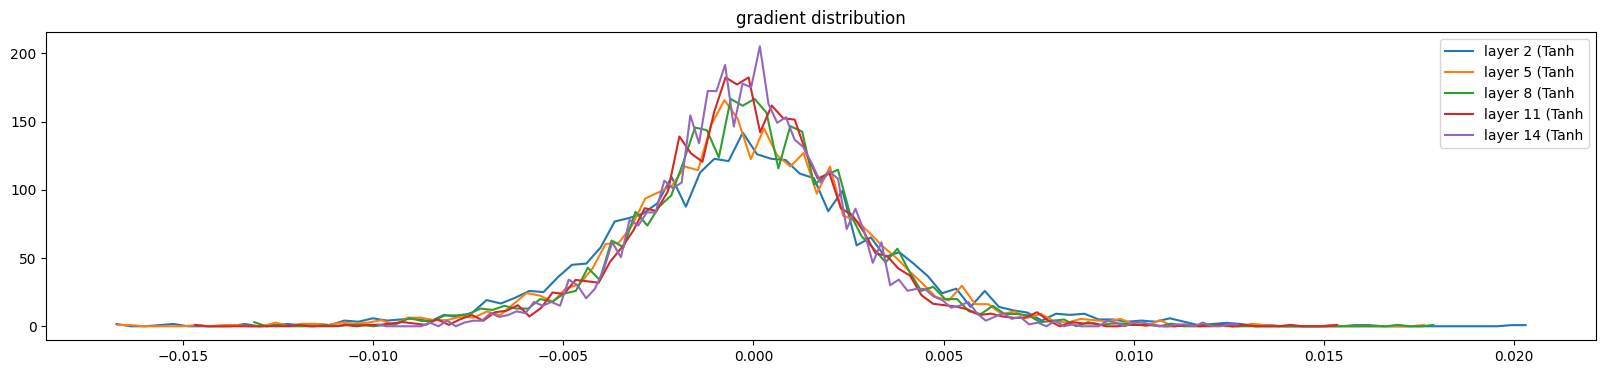

In [71]:
#visualize the histograms

# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')


weight   (27, 10) | mean -0.000000 | std 1.019888e-02 | grad:data ratio 1.018849e-02
weight  (30, 100) | mean +0.000092 | std 8.238437e-03 | grad:data ratio 2.635841e-02
weight (100, 100) | mean +0.000031 | std 7.318118e-03 | grad:data ratio 4.377148e-02
weight (100, 100) | mean -0.000019 | std 6.662027e-03 | grad:data ratio 3.949898e-02
weight (100, 100) | mean -0.000019 | std 5.821519e-03 | grad:data ratio 3.468163e-02
weight (100, 100) | mean +0.000053 | std 5.445300e-03 | grad:data ratio 3.243370e-02
weight  (100, 27) | mean -0.000165 | std 1.046846e-02 | grad:data ratio 6.281270e-02


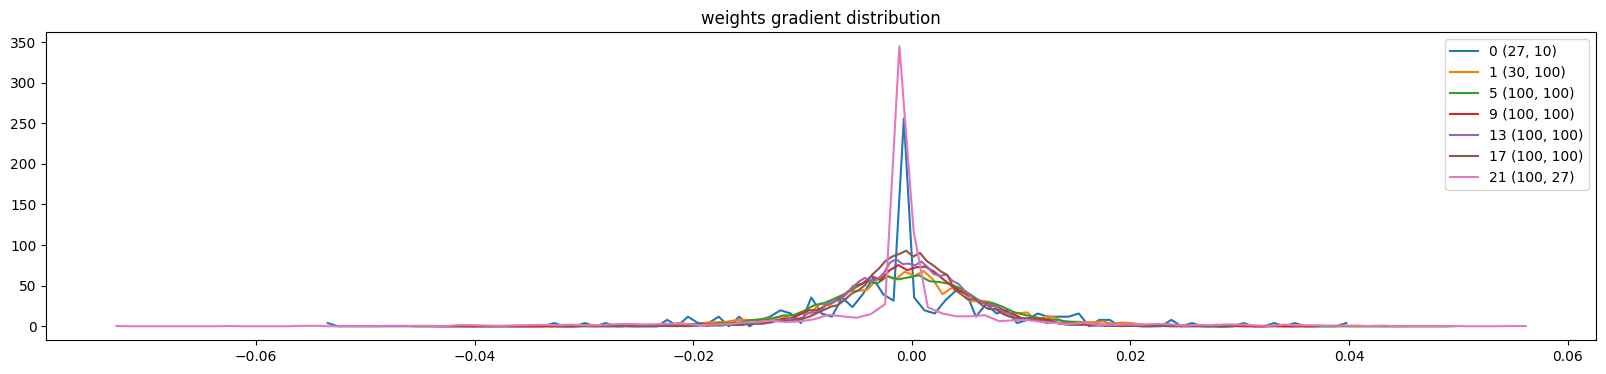

In [72]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

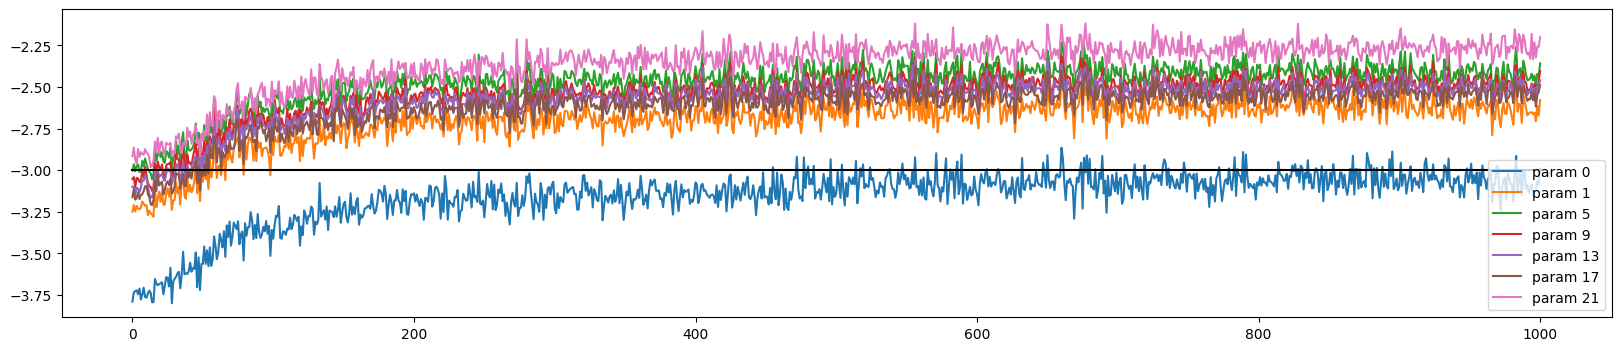

In [73]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [68]:
# now applying batch normalization
n_embd = 10 # the dimensionality of the charcter embedding vectors
n_hidden = 100
g = torch.Generator().manual_seed(2147483647) 
C = torch.randn((vocab_size,n_embd), generator=g)
block_size = 3
layers = [
    Linear(n_embd*block_size,n_hidden),BatchNorm1d(n_hidden),Tanh(),
    Linear(n_hidden,n_hidden),BatchNorm1d(n_hidden),Tanh(),
    Linear(n_hidden,n_hidden),BatchNorm1d(n_hidden),Tanh(),
    Linear(n_hidden,n_hidden),BatchNorm1d(n_hidden),Tanh(),
    Linear(n_hidden,n_hidden),BatchNorm1d(n_hidden),Tanh(),
    Linear(n_hidden,vocab_size),BatchNorm1d(vocab_size),


]

with torch.no_grad():
    # last layer : make less confident
    # layers[-1].weight *=0.1
    layers[-1].gamma *= 0.1

    #all other layers : apply gain
    for layer in layers[:-1]:
        if isinstance(layer,Linear):
            layer.weight *=5/3


parameters = [C] + [p for layer in layers for p in layer.parameters()]

print( sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

47551


In [69]:
max_steps  = 200000
batch_size = 32
lossi =[]
ud = []
for i in range(max_steps):

    #minibatch construct
    ix = torch.randint(0,Xtr.shape[0],(batch_size,),generator=g)
    Xb,Yb = Xtr[ix],Ytr[ix] # batch X, Y

    #forward pass
    emb = C[Xb] #embed the characters into vectors
    x =emb.view(emb.shape[0],-1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) #loss function

    #backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG :would take out retain_graph

    for p in parameters:
        p.grad = None
    loss.backward()

    # update

    lr = 0.1 if i < 100000 else 0.01

    for p in parameters:
        p.data  += -lr * p.grad


    #track stats
    
    if i % 10000 == 0: # print every once n a while

        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')

    lossi.append(loss.log10().item())

    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])
    
    if i >= 1000:
        break # AFTER_DEBUG: would take out obviously to run full optimization  

      0/ 200000: 3.2870
